# Fourier Neural Operator - Navier Stokes 2D

In this notebook we'll train the Fourier Neural Operator for 2D equations. We'll use the Navier Stokes equation as an example.

The Navier Stokes equation is given by

$$
\begin{align*}
\partial_t w(x,t) + u(x,t) \cdot \nabla w(x,t) &= \nu \Delta w(x,t) + f(x)\\
\nabla \cdot u(x,t) &= 0\\
w(x,0) &= w_0(x)
\end{align*}
$$

where $w(x,t)$ is the velocity field, $u(x,t)$ is the vortex field, $\nu$ is the viscosity, and $f(x)$ is the forcing term.

## Libraries

In [10]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

# Numpy
import numpy as np

# Scipy
import scipy.io

# h5py for loading mat file
import h5py

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc

# IPython for displaying the animation
from IPython.display import HTML
rc('animation', html='jshtml')

# itertools for iterating through the list
from itertools import islice as take

# Tqdm for the progress bar
from tqdm import trange

# Set the random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print GPUs device name
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print("GPU",i,":",torch.cuda.get_device_name(i))

GPU 0 : NVIDIA A100-PCIE-40GB


## Fourier Neural Operator

Now we can define the Fourier Neural Operator.

### 3D Fourier convolution neural network

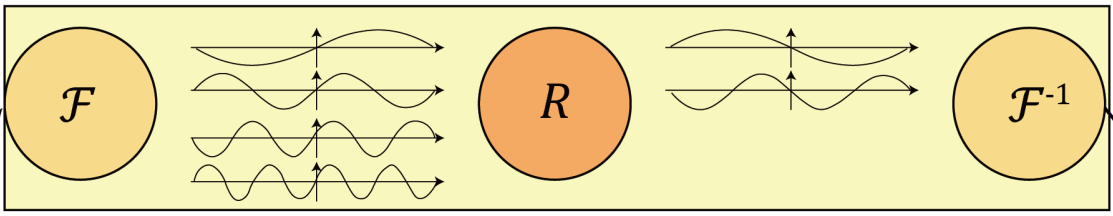

$$(R\cdot (\mathcal{F}v_t))_{k,l} = \sum_{j=i}^{d_v}R_{k,l,j}(\mathcal{F}v_t)_k,j$$

$$(\mathcal{K}(\phi)v_t)(x) = \mathcal{F}^{-1}\left((R\cdot (\mathcal{F}v_t\right)(x)$$

In [3]:
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # 2 modes per dimension max, i.e. 6 modes
        self.modes = modes  
    
        # Scale used to initialize weights
        self.scale = (1 / (in_channels * out_channels))
        
        # Weights for different convolution operations in Fourier space
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, modes,
                                                             modes, dtype=torch.cfloat))
        
    def complex_multi_3D(self, inputs, weights):
        # Complex multiplication between inputs and weights
        return torch.einsum("bixyz,ioxyz->boxyz", inputs, weights)
    
    def forward(self, x):
        batchsize = x.shape[0]
        
        # Calculating the Fourier coefficients, i.e. applying FFT to x and swapping the order of dimensions
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])
        
        # Initialize output tensor in Fourier space with the following dimension [batch, out, x[-3], x[-2], x[-1]/2]
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        # Multiply the relevant Fourier modes with the corresponding weights
        out_ft[:, :, :self.modes, :self.modes, :self.modes] = self.complex_multi_3D(x_ft[:, :, :self.modes, :self.modes, :self.modes], self.weights1)
        
        out_ft[:, :, -self.modes:, :self.modes, :self.modes] = self.complex_multi_3D(x_ft[:, :, -self.modes:, :self.modes, :self.modes], self.weights2)
        
        out_ft[:, :, :self.modes, -self.modes:, :self.modes] = self.complex_multi_3D(x_ft[:, :, :self.modes, -self.modes:, :self.modes], self.weights3)

        out_ft[:, :, -self.modes:, -self.modes:, :self.modes] = self.complex_multi_3D(x_ft[:, :, -self.modes:, -self.modes:, :self.modes], self.weights4)
        
        
        # Calculate the inverse Fourier transform to get the final output in real space
        result = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return result

### Fourier Block Neural Network
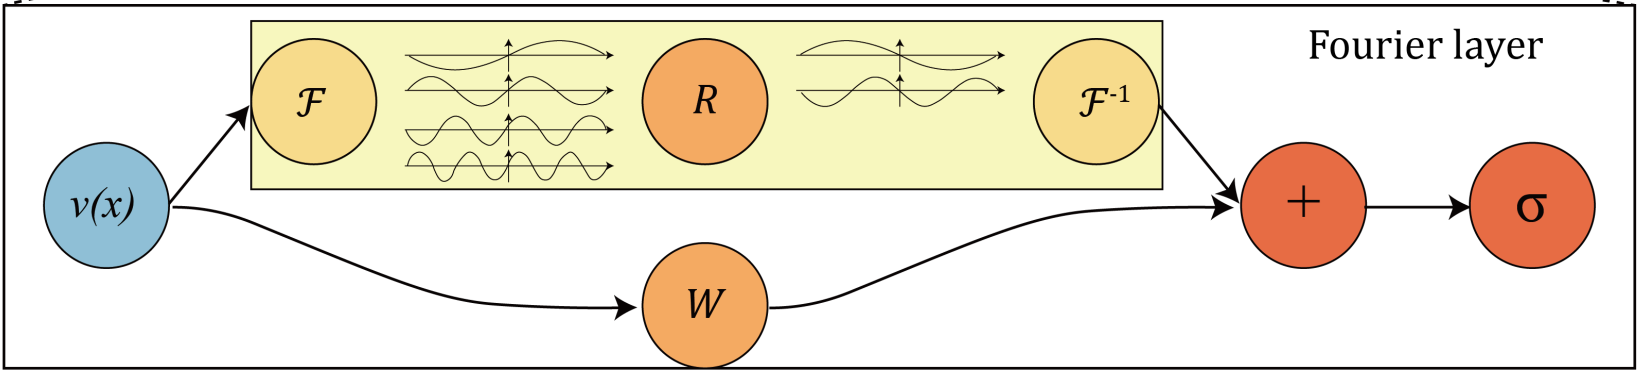
$$\sigma\left(Wv_t(x)+(\mathcal{K}(a,\phi)v_t)(x)\right)$$

where $W$ is a linear operator, $a$ is a vector of learnable parameters, $\phi$ is a vector of learnable parameters, and $\sigma$ is a non-linear activation function.

In [4]:
class FourierLayerBlock(nn.Module):
    def __init__(self, modes, width):
        super(FourierLayerBlock, self).__init__()
        self.modes = modes
        self.width = width
        
        # 3D Fourier Spectral Convolution Layer
        self.rama_superior = SpectralConv3d(self.width, self.width, self.modes)
        
        # 1D Convolution Layer
        self.rama_inferior = nn.Conv1d(self.width, self.width, 1)
        
    def forward(self, x, batchsize, size_x, size_y, size_z):
        # Forward pass in the upper branch (3D Fourier Spectral Convolution Layer)
        x_sup = self.rama_superior(x)
        
        # Forward pass in the lower branch (1D Convolution Layer) (W)
        x_inf = self.rama_inferior(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        
        # Sum the outputs of both branches and apply a ReLU activation function
        x = x_sup + x_inf # (+)
        x = F.relu(x) # (𝜎)
        return x

### 3D Fourier Neural Operator

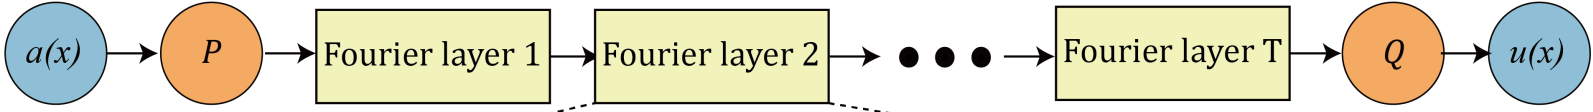

is the 3D Fourier Neural Operator. 3 dimensions are $x$, $y$, and $t$.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class FNO3D(nn.Module):
    def __init__(self, modes, width, T_in, T_out, layers=4):
        """
        modes  - number of Fourier modes to keep
        width  - channel width of the hidden representation
        T_in   - number of historical time-steps fed in
        T_out  - number of time-steps to predict (unused in forward, 
                  but may be needed downstream for loss or scheduling)
        layers - number of FourierLayerBlocks
        """
        super(FNO3D, self).__init__()
        self.modes = modes
        self.width = width
        self.layers = layers
        self.T_in  = T_in
        self.T_out = T_out

        # we’ll set these once we see data in forward()
        self.S  = 0
        self.T  = 0

        # === P-layer: 3 coords + T_in history channels → width
        self.fc0 = nn.Linear(4, self.width)

        # stack of spectral blocks
        self.module = nn.ModuleList([
            FourierLayerBlock(self.modes, self.width)
            for _ in range(self.layers)
        ])

        # final “pointwise” nets
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x: [batch, Sx, Sy, T_in]
        batch, Sx, Sy, T = x.shape
        # on first pass (or if grid size changes), build coordinate grids
        if self.S != Sx or self.T != T:
            self.set_grid(Sx, Sy, T, x.device)

        # attach coords + broadcast last‐dim feature
        # x.unsqueeze(-1): → [batch, Sx, Sy, T, 1]
        x_feat = x.unsqueeze(-1)

        # concat coordinate channels: → [batch, Sx, Sy, T, 1+3]
        gx = self.gridx.repeat(batch, 1, 1, 1, 1)
        gy = self.gridy.repeat(batch, 1, 1, 1, 1)
        gt = self.gridt.repeat(batch, 1, 1, 1, 1)

        x_cat = torch.cat([gx, gy, gt, x_feat], dim=-1)

        # input projection
        x_proj = self.fc0(x_cat)  # → [batch, Sx, Sy, T, width]
        # reorder for spectral blocks: [batch, width, Sx, Sy, T]
        x_spec = x_proj.permute(0, 4, 1, 2, 3)

        # spectral layers
        for block in self.module:
            x_spec = block(x_spec)

        # back to [batch, Sx, Sy, T, width]
        x_out = x_spec.permute(0, 2, 3, 4, 1)
        # pointwise MLP
        x_out = F.relu(self.fc1(x_out))
        x_out = self.fc2(x_out)   # → [batch, Sx, Sy, T, 1]
        return x_out.squeeze(-1)  # → [batch, Sx, Sy, T]

    def set_grid(self, Sx, Sy, T, device):
        """Build normalized coordinate grids once per shape."""
        self.S = Sx
        self.T = T
        self.Sx = Sx
        self.Sy = Sy
        self.T = T

        # x & y ∈ [0,1], t ∈ [0,1]
        xs = torch.linspace(0, 1, Sx, device=device)
        ys = torch.linspace(0, 1, Sy, device=device)
        ts = torch.linspace(0, 1, T, device=device)

        # shape into [1, Sx, Sy, T, 1]
        self.gridx = xs.view(1, Sx, 1, 1, 1).repeat(1, 1, Sy, T, 1)
        self.gridy = ys.view(1, 1, Sy, 1, 1).repeat(1, Sx, 1, T, 1)
        self.gridt = ts.view(1, 1, 1, T, 1).repeat(1, Sx, Sy, 1, 1)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# ───────────────────────────────────────────────────────────
# Fourier Layer Block
# ───────────────────────────────────────────────────────────
class FourierLayerBlock(nn.Module):
    """
    A single FNO block:
      • Spectral 3-D convolution  (x_sup)
      • Channel-wise 1-D conv     (x_inf)
      • ReLU on the sum
    """
    def __init__(self, modes: int, width: int):
        super().__init__()
        self.rama_sup = SpectralConv3d(width, width, modes)
        self.rama_inf = nn.Conv1d(width, width, kernel_size=1)

    def forward(self, x):
        """
        x: [B,  C=width, Sx, Sy, Sz]   (Sz == T_out)
        """
        B, C, Sx, Sy, Sz = x.shape

        # spectral branch
        x_sup = self.rama_sup(x)

        # 1-D point-wise branch
        x_inf = self.rama_inf(x.view(B, C, -1))          # [B, C, Sx*Sy*Sz]
        x_inf = x_inf.view(B, C, Sx, Sy, Sz)

        # non-linearity
        return F.relu(x_sup + x_inf)


# ───────────────────────────────────────────────────────────
# 3-D Fourier Neural Operator
# ───────────────────────────────────────────────────────────
class FNO3D(nn.Module):
    """
    • Input  : [B, Sx, Sy, T_in]                (history cube)
    • Output : [B, Sx, Sy, T_out]               (forecast cube)
    """
    def __init__(self,
                 modes:  int,
                 width:  int,
                 T_in:   int,
                 T_out:  int,
                 layers: int = 4):
        super().__init__()

        self.modes   = modes
        self.width   = width
        self.layers  = layers
        self.T_in    = T_in
        self.T_out   = T_out

        # Linear projection: 3 coords  +  T_in history  →  width
        self.fc0 = nn.Linear(T_in + 3, width)

        # Fourier blocks
        self.fblocks = nn.ModuleList(
            [FourierLayerBlock(modes, width) for _ in range(layers)]
        )

        # Final point-wise MLP
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

        # coordinate buffers (lazy)
        self.gridx = self.gridy = self.gridt = None
        self.Sx = self.Sy = self.Sz = 0       # cache grid sizes

    # ───────────────────────────────────────────────
    # forward
    # ───────────────────────────────────────────────
    def forward(self, x):
        """
        x : [B, Sx, Sy, T_in]
        """
        B, Sx, Sy, T_in = x.shape
        assert T_in == self.T_in, "Input tensor’s T dimension ≠ T_in"

        # (re-)build coordinate grids if shape changed
        if (Sx, Sy, self.T_out) != (self.Sx, self.Sy, self.Sz) or self.gridx is None:
            self._build_grid(Sx, Sy, x.device)

        # ----- create feature tensor --------------------------------------
        # history → feature axis,  then replicate along forecast time Sz
        #   x_feat : [B, Sx, Sy, Sz, T_in]
        x_feat = x.unsqueeze(3).repeat(1, 1, 1, self.Sz, 1)

        # concat coords (each  [1,Sx,Sy,Sz,1]  → broadcast to batch)
        gx = self.gridx.expand(B, -1, -1, -1, -1)
        gy = self.gridy.expand(B, -1, -1, -1, -1)
        gt = self.gridt.expand(B, -1, -1, -1, -1)

        # [B, Sx, Sy, Sz, T_in + 3]
        x_cat = torch.cat([gx, gy, gt, x_feat], dim=-1)

        # ----- point-wise projection  -------------------------------------
        # result : [B, Sx, Sy, Sz, width]
        x = self.fc0(x_cat)

        # transpose for Fourier blocks: [B, width, Sx, Sy, Sz]
        x = x.permute(0, 4, 1, 2, 3)

        # ----- spectral stack  -------------------------------------------
        for blk in self.fblocks:
            x = blk(x)

        # back to  [..., width] last
        x = x.permute(0, 2, 3, 4, 1)          # [B, Sx, Sy, Sz, width]

        # ----- point-wise head  ------------------------------------------
        x = F.relu(self.fc1(x))
        x = self.fc2(x).squeeze(-1)           # [B, Sx, Sy, Sz]

        return x                              # == forecast [T_out] cube

    # ───────────────────────────────────────────────
    # helper: build coord grids
    # ───────────────────────────────────────────────
    def _build_grid(self, Sx, Sy, device):
        self.Sx, self.Sy, self.Sz = Sx, Sy, self.T_out

        xs = torch.linspace(0, 1, Sx, device=device)
        ys = torch.linspace(0, 1, Sy, device=device)
        ts = torch.linspace(0, 1, self.T_out, device=device)

        # → shape  [1, Sx, Sy, Sz, 1]
        self.gridx = xs.view(1, Sx, 1, 1, 1).repeat(1, 1, Sy, self.T_out, 1)
        self.gridy = ys.view(1, 1, Sy, 1, 1).repeat(1, Sx, 1, self.T_out, 1)
        self.gridt = ts.view(1, 1, 1, self.T_out, 1).repeat(1, Sx, Sy, 1, 1)



## Loss Function

In [7]:
# Loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        # Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

## Training

### Data preparation

We'll train the model with pre-generated data. We'll use the Navier Stokes data with the following parameters:

- `visc = 1e-5`
- `tmax = 20`
- `x = 64`
- `y = 64`
- `n = 1200`

In [15]:
dummy_value = 0.0

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import xarray as xr

# 1. Load the SST dataset
ds = xr.tutorial.open_dataset('ersstv5')
sst = ds['sst']

sst = sst.fillna(dummy_value)  
# shape = (T, H, W)
data = sst.values.astype('float32')
T, H, W = data.shape

# 2. Define sliding‐window parameters
T_in   = 12                     # number of input time steps
T_pred = 12              # number of steps to predict
step   = 1                       # sliding window stride
# total number of (input, target) pairs
n_samples = (T - (T_in + T_pred)) // step + 1

# 3. Build arrays of shape (n_samples, H, W, T_in) and (n_samples, H, W, T_pred)
X = np.zeros((n_samples, T_in, H, W),  dtype='float32')
Y = np.zeros((n_samples, T_pred, H, W), dtype='float32')

for i in range(n_samples):
    start = i * step
    X[i] = data[start : start + T_in]
    Y[i] = data[start + T_in : start + T_in + T_pred]

# 4. Move time‐axis to last dim for FNO convention (batch, H, W, T)
X = np.transpose(X, (0, 2, 3, 1))
Y = np.transpose(Y, (0, 2, 3, 1))

# 5. Split into train / eval / test
ntrain = int(0.8 * n_samples)
neval  = int(0.2 * ntrain)
ntest  = n_samples - ntrain

# train
train_X = torch.from_numpy(X[:ntrain])
train_Y = torch.from_numpy(Y[:ntrain])
# eval (from end of train split)
eval_X = torch.from_numpy(X[ntrain : ntrain+neval])
eval_Y = torch.from_numpy(Y[ntrain : ntrain+neval])
# test (the remainder)
test_X = torch.from_numpy(X[ntrain+neval :])
test_Y = torch.from_numpy(Y[ntrain+neval :])

# 6. Create DataLoaders
batch_size = 10

train_loader = DataLoader(TensorDataset(train_X, train_Y),
                          batch_size=batch_size, shuffle=True)
eval_loader  = DataLoader(TensorDataset(eval_X,  eval_Y),
                          batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(test_X,  test_Y),
                          batch_size=batch_size, shuffle=False)

# confirm shapes
print(f"Train: {train_X.shape} → {train_Y.shape}")
print(f"Eval:  {eval_X.shape} → {eval_Y.shape}")
print(f"Test:  {test_X.shape} → {test_Y.shape}")


Train: torch.Size([480, 89, 180, 12]) → torch.Size([480, 89, 180, 12])
Eval:  torch.Size([96, 89, 180, 12]) → torch.Size([96, 89, 180, 12])
Test:  torch.Size([25, 89, 180, 12]) → torch.Size([25, 89, 180, 12])


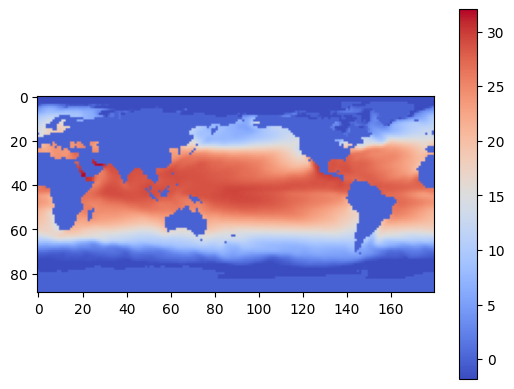

In [16]:
plt.imshow(sst.isel(time=30), cmap='coolwarm')
plt.colorbar()

### Functions for training

#### Function to train an epoch

In [17]:
sst = ds['sst']
mask = torch.tensor(~np.isnan(sst.values)[0], device=device).unsqueeze(-1)

def train_epoch(dataloader, model, optimizer, scheduler, loss_function):
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y = y * mask
        B, sx, sy, _ = x.shape
        out = (model(x) * mask).view(B, sx, sy, T_pred)
        loss = loss_function(out.view(B, -1), y.view(B, -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    model.eval()


#### Function to evaluate an epoch

In [18]:
def eval_epoch(dataloader, model, loss_function, num_batches=None):
    # Freeze model parameters
    with torch.no_grad():
        # Historiales
        losses, mses = [], []
        
        # Evaluates this epoch with num_batches
        test_l2 = 0
        for a, u_true in take(dataloader, num_batches):
            B, sx, sy, _ = a.shape
            a = a.to(device)
            u_true = u_true.to(device)
            u_true = u_true * mask
            
            out = model(a*mask).view(B, sx, sy, T_pred)
            
            # Evaluamos con las funciones de perdida
            test_l2 = loss_function(out.view(1, -1), u_true.view(1, -1)).item()
            test_mse = F.mse_loss(out.view(1, -1), u_true.view(1, -1), reduction='mean')
            losses.append(test_l2)
            mses.append(test_mse.cpu())
            
        # Get mean loss and mean mse
        loss = np.mean(losses)
        mse = np.mean(mses)
        
        return loss, mse

#### Function to train the model

In [19]:
def train_model(model, train_dataloader, test_dataloader, lr=1e-3, epochs=20, scheduler_step=100, scheduler_gamma=0.05, train_batches=None, test_batches=None):
    # Función de pérdida
    loss_function = LpLoss(size_average=False)
    # loss_function = torch.nn.L1Loss()
    
    # Usamos al optimizador Adam
    # opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Usamos el scheduler StepLR para reducir de manera constante el learning rate después de ciertos pasos
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=scheduler_step, gamma=scheduler_gamma)
    
    # Inicializamos los historiales
    loss_hist, mse_hist = [], []
    
    # Entrenamos
    for epoch in trange(epochs):
        
        # Entrenamos la época
        train_epoch(train_dataloader, model, opt, scheduler, loss_function)

        # Evaluamos la época en entrenamiento
        trn_loss, trn_mse = eval_epoch(train_dataloader, model, loss_function, train_batches)
        
        # Evaluamos la época en prueba
        tst_loss, tst_mse = eval_epoch(test_dataloader, model, loss_function, test_batches)

        # Guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        mse_hist.append([trn_mse, tst_mse])
        
    return loss_hist, mse_hist

### Training the model

In [20]:
# Create model
model = FNO3D(modes=6, width=20, T_in=T_in, T_out=T_pred).to(device)

In [21]:
# Train model
loss_hist, mse_hist = train_model(model, train_loader, eval_loader, lr=1e-4, epochs=100)

100%|██████████| 100/100 [48:30<00:00, 29.11s/it]


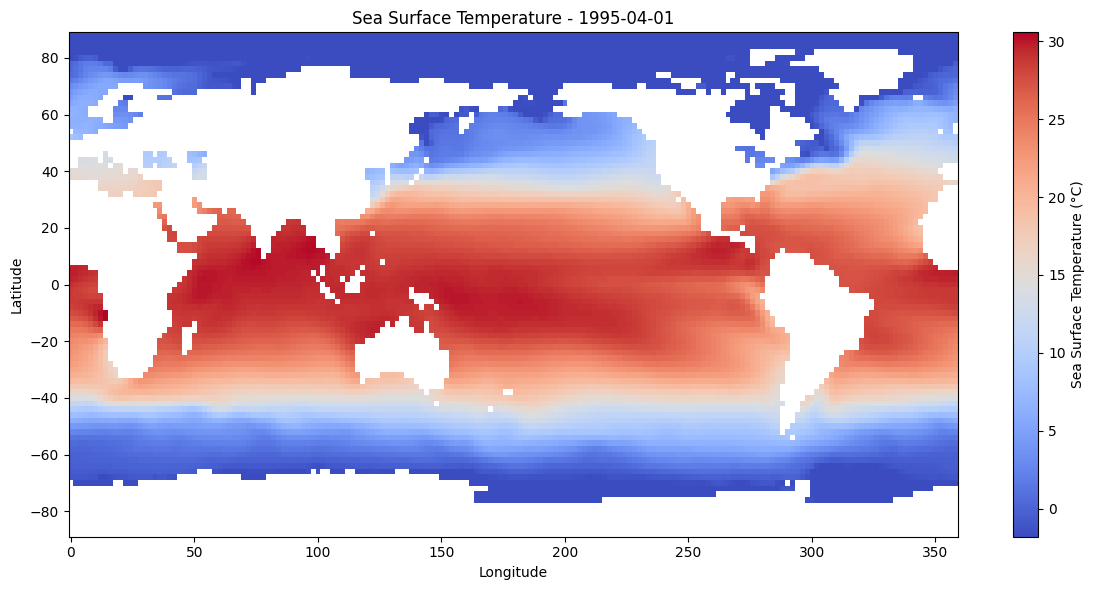

In [24]:
idx = 303

# The SST variable is typically named 'sst', with dimensions (time, lat, lon)
# Select the first time slice for visualization (or choose a specific date)
sst = ds['sst'].isel(time=idx)

# Mask missing values (usually -999.9)
sst = sst.where(sst != sst.attrs.get('_FillValue', -999.9))

# Plot using pcolormesh for correct coordinate alignment
plt.figure(figsize=(12, 6))
plt.pcolormesh(ds['lon'], ds['lat'], sst, shading='auto', cmap='coolwarm')
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.title(f'Sea Surface Temperature - {str(ds["time"].values[idx])[:10]}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


In [17]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Load the dataset
ds = xr.tutorial.open_dataset('ersstv5')

# Mask missing values
fill_value = ds['sst'].attrs.get('_FillValue', -999.9)
sst = ds['sst'].where(ds['sst'] != fill_value)
sst = sst[:100]

# Setup figure
fig, ax = plt.subplots(figsize=(12, 6))
cmap = 'coolwarm'
vmin = float(sst.min().values)
vmax = float(sst.max().values)

# Initial frame
# mesh = ax.pcolormesh(ds['lon'], ds['lat'], sst.isel(time=0), shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
img = ax.imshow(sst.isel(time=0), cmap=cmap, vmin=vmin, vmax=vmax, 
                 extent=[float(ds['lon'].min()), float(ds['lon'].max()),
                         float(ds['lat'].min()), float(ds['lat'].max())],
                 )

# create title once, grab the Text handle
title = ax.set_title(f'SST – {str(ds["time"].values[0])[:10]}')

# ── Animation callback ──────────────────────────────────────────────
def update(frame):
    img.set_data(sst.isel(time=frame))
    title.set_text(f'SST - {str(ds["time"].values[frame])[:10]}')
    return [img, title]                # include title for blitting

# def update(frame):
#     img.set_data(sst.isel(time=frame))
#     # img.set_title(f'AMOC at Time Step {frame}')
#     return [img]


# Create the animation
amoc_ani = FuncAnimation(fig, update, frames=len(sst['time']), interval=200, blit=True)

# Display the animation
HTML(amoc_ani.to_jshtml())


SyntaxError: f-string: unmatched '[' (3626570636.py, line 35)

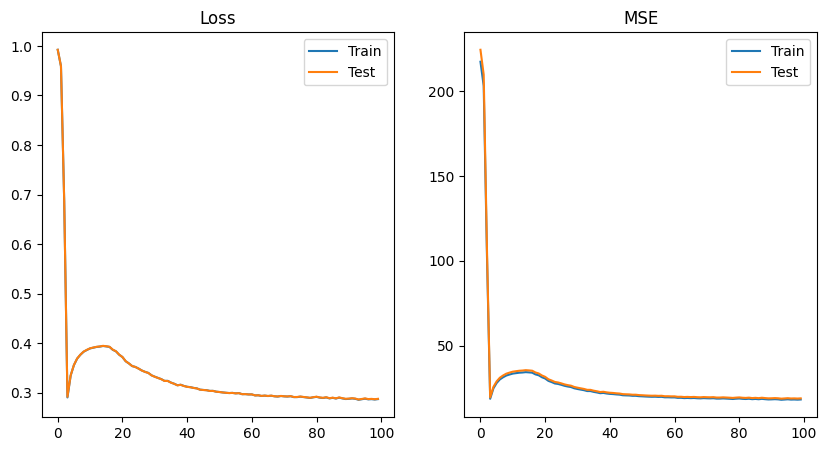

In [14]:
# Separate train and test loss as well as train and test mse
train_loss_hist = [loss[0] for loss in loss_hist]
test_loss_hist = [loss[1] for loss in loss_hist]
train_mse_hist = [mse[0] for mse in mse_hist]
test_mse_hist = [mse[1] for mse in mse_hist]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_loss_hist, label='Train')
ax[0].plot(test_loss_hist, label='Test')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(train_mse_hist, label='Train')
ax[1].plot(test_mse_hist, label='Test')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

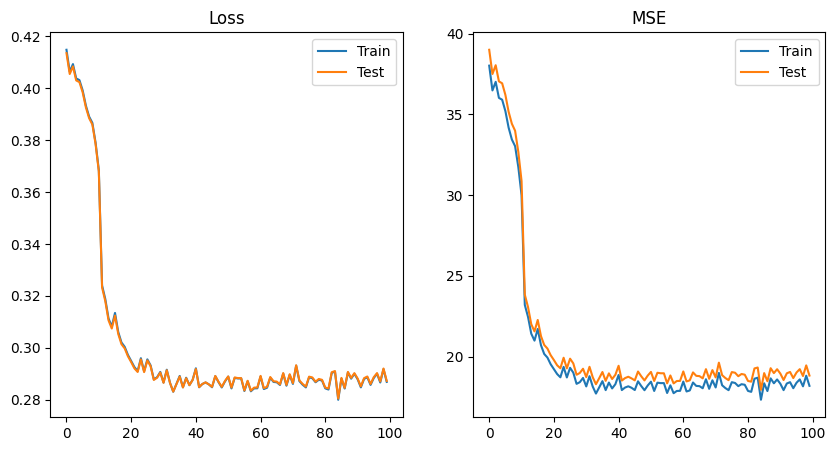

In [24]:
# Separate train and test loss as well as train and test mse
train_loss_hist = [loss[0] for loss in loss_hist]
test_loss_hist = [loss[1] for loss in loss_hist]
train_mse_hist = [mse[0] for mse in mse_hist]
test_mse_hist = [mse[1] for mse in mse_hist]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_loss_hist, label='Train')
ax[0].plot(test_loss_hist, label='Test')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(train_mse_hist, label='Train')
ax[1].plot(test_mse_hist, label='Test')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

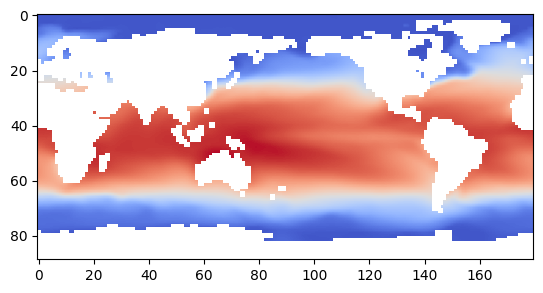

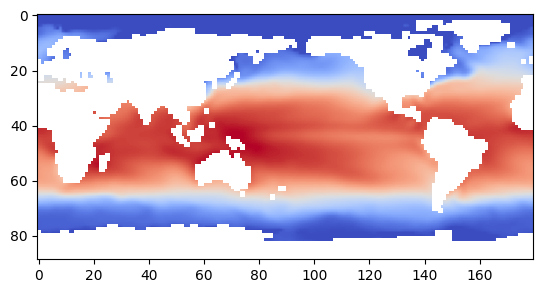

In [29]:
x, y = next(iter(eval_loader))
x = x.to(device)
y = y.to(device)
predict = model(x)*mask
predict[~mask.expand(10, 89, 180, 12)] = np.nan
y[~mask.expand(10, 89, 180, 12)] = np.nan
plt.imshow(predict[0,..., 0].cpu().detach().numpy(), cmap='coolwarm')
plt.figure()
plt.imshow(y[0,..., 0].cpu().detach().numpy(), cmap='coolwarm')